In this Jupyter notebook, we perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier. The result will be saved and will be used in vehicle detection.

Traning data: [vehicles](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles_smallset.zip) and [non-vehicles](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles_smallset.zip)

Output: binary output (`1` means 'car', `0` means 'no car')

Method: Support Vector Machine Classifier (SVC) with Linear Kernel 


In [1]:
import numpy as np
import cv2
import glob
import time

from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
import sklearn
print('The version of scikit-learn I am using is {}.'.format(sklearn.__version__))

The version of scikit-learn I am using is 0.18.


In [3]:
from sklearn.model_selection import train_test_split

## Data Exploration

In [4]:
cars = glob.glob('./vehicles/**/*.png', recursive = True)
notcars = glob.glob('./non-vehicles/**/*.png', recursive = True)

print('There are {} images in total who contained a car. And,'.format(len(cars)))
print('there are {} images in total who contained no car.'.format(len(notcars)))

There are 8792 images in total who contained a car. And,
there are 8968 images in total who contained no car.


**Notes.** We assumed here that there is no duplication in the data. To be prudent, one needs to check the replication of contents in 'KITTI_extracted' and others.

In [5]:
# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    img_example = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = img_example.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = img_example.dtype
    # Return data_dict
    return data_dict

Your function returned a count of 8792  cars and 8968  non-cars
They are of size:  (64, 64, 3)  and of data type: float32


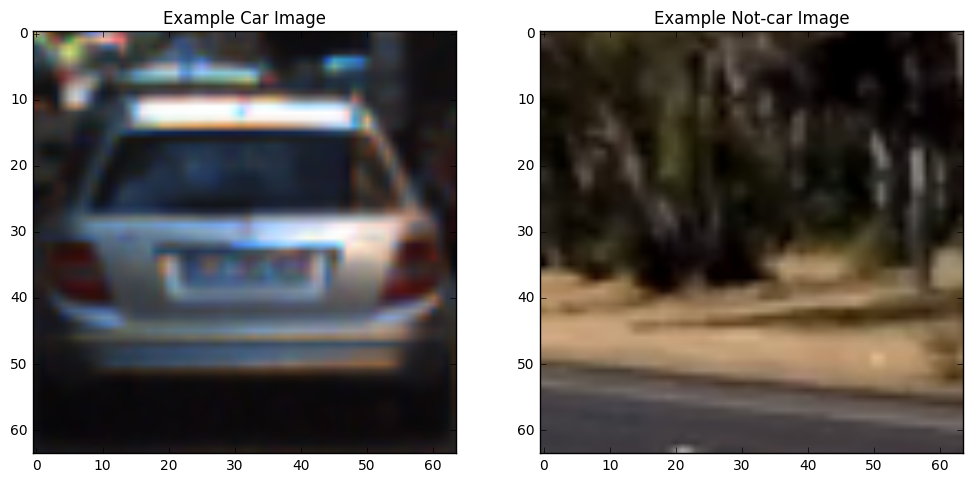

In [7]:
data_info = data_look(cars, notcars)

print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('They are of size: ',data_info["image_shape"], ' and of data type:', 
      data_info["data_type"])
# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])


# Plot the examples
fig = plt.figure(figsize=(12,8))
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')
plt.savefig("./output_images/data_exploration.jpg")

From above, we find the number of vehicle images and non-vehicle images are almost the same. Applying rule of 30, the sensibility of accuracy is around 0.5%. So we decide to train a classifier based on these data and don't do augumentations. 

## Histogram of Oriented Gradients (HOG) Feature Extraction

In [8]:
# First, define a function to return HOG features and visualization

def get_hog_features(img, 
                     orient, 
                     pix_per_cell, 
                     cell_per_block, 
                     vis=False, 
                     feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, 
                                  orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=True, 
                                  feature_vector=False)
        return features, hog_image
    else:      
        features = hog(img, 
                       orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=False, 
                       feature_vector=feature_vec)
        return features

### Tune HOG Parameter

In [11]:
# Tune HOG parameters
orient = 8
pix_per_cell = 8
cell_per_block = 1

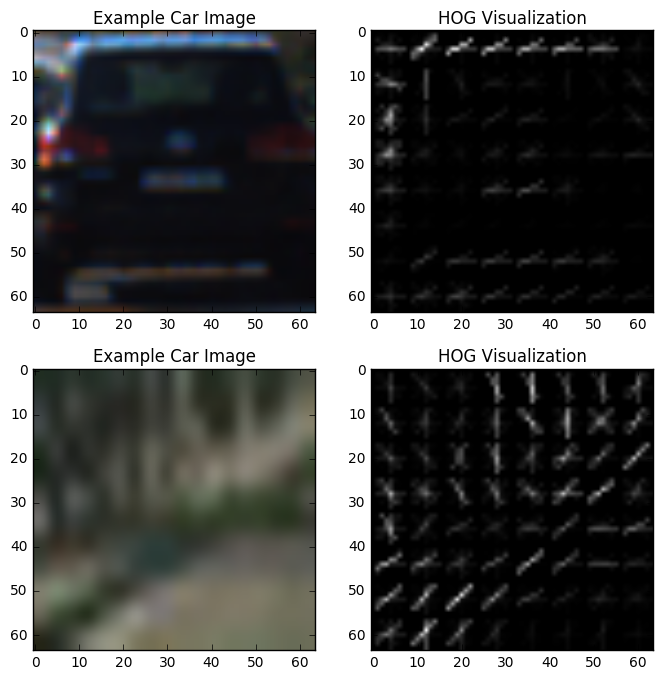

In [14]:
# Generate a random index to look at a car and a not-car image
ind_car = np.random.randint(0, len(cars))
ind_notcar = np.random.randint(0, len(notcars))
# Read in the image
image_car = mpimg.imread(cars[ind_car])
image_notcar = mpimg.imread(notcars[ind_notcar])
car_gray = cv2.cvtColor(image_car, cv2.COLOR_RGB2GRAY)
notcar_gray = cv2.cvtColor(image_notcar, cv2.COLOR_RGB2GRAY)

# Call our function with vis=True to see an image output
features_car, hog_image_car = get_hog_features(car_gray, 
                                               orient, 
                                               pix_per_cell, 
                                               cell_per_block, 
                                               vis=True, 
                                               feature_vec=False)

features_notcar, hog_image_notcar = get_hog_features(notcar_gray, 
                                                     orient, 
                                                     pix_per_cell, 
                                                     cell_per_block, 
                                                     vis=True, 
                                                     feature_vec=False)

# Plot the examples

fig = plt.figure(figsize=(8,8))
plt.subplot(221)
plt.imshow(image_car, cmap='gray')
plt.title('Example Car Image')
plt.subplot(222)
plt.imshow(hog_image_car, cmap='gray')
plt.title('HOG Visualization')
plt.subplot(223)
plt.imshow(image_notcar, cmap='gray')
plt.title('Example Car Image')
plt.subplot(224)
plt.imshow(hog_image_notcar, cmap='gray')
plt.title('HOG Visualization')
plt.savefig("./output_images/hog_v3.jpg")

In [15]:
# The following function is to extract features from a list of images

def extract_features(imgs, 
                     cspace='YCrCb', 
                     orient=8, 
                     pix_per_cell=8, 
                     cell_per_block=1, 
                     hog_channel='ALL'):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image == cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image == cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: 
            feature_image = np.copy(image)
        
        # Call get_hog_features() function with vis = False, feature_vec = True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel],
                                                     orient,
                                                     pix_per_cell,
                                                     cell_per_block,
                                                     vis = False,
                                                     feature_vec = True))
            hog_features = np.ravel(hog_features)
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel],
                                            orient,
                                            pix_per_cell,
                                            cell_per_block,
                                            vis = False,
                                            feature_vec = True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    return features

## Training

In this subsection, we train a Linear SVM classifier based on data 'cars' and 'notcars'.

### Parameters

After many experiments, I set parameters as follows.

In [16]:
colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 8
pix_per_cell = 8
cell_per_block = 1
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

In [17]:
t1=time.time()

car_features = extract_features(cars, 
                                cspace=colorspace, 
                                orient=orient, 
                                pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel)
notcar_features = extract_features(notcars, 
                                   cspace=colorspace, 
                                   orient=orient, 
                                   pix_per_cell=pix_per_cell, 
                                   cell_per_block=cell_per_block, 
                                   hog_channel=hog_channel)

t2 = time.time()

print('It takes {} seconds to extract HOG features.'.format(round(t2-t1, 2)))

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64) 

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)

It takes 153.47 seconds to extract HOG features.


In [18]:
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations', pix_per_cell,
    'pixels per cell and', cell_per_block, 'cells per block')
print('Feature vector length:', len(X_train[0]))

# Use a linear SVC 
svc = LinearSVC()

# Check the training time for the SVC
t1 = time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print('It takes {} seconds to train SVC.'.format(round(t2-t1, 2)))

Using: 8 orientations 8 pixels per cell and 1 cells per block
Feature vector length: 1536
It takes 5.56 seconds to train SVC.


### Test Accuracy

In [19]:
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

# Check the prediction time for a single sample
t = time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t1, 5), 'Seconds to predict', n_predict,'labels with SVC')

Test Accuracy of SVC =  0.9775
My SVC predicts:  [ 0.  1.  0.  0.  0.  0.  1.  1.  1.  0.]
For these 10 labels:  [ 0.  1.  1.  0.  0.  0.  1.  1.  1.  0.]
5.58967 Seconds to predict 10 labels with SVC


### Save the Model

In [20]:
import pickle

pickle.dump(svc, open("saved_svc_YCrCb.p", "wb"))
pickle.dump(X_scaler, open("saved_X_scaler_YCrCb.p", "wb"))